# Unit 5 - Financial Planning

## Part 1 - Personal Finance Planner

### Intial Imports

In [1]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline
import json

In [2]:
load_dotenv()

True

#### Crypto Prices

In [7]:
my_btc = 1.2
my_eth = 5.3
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
btc_url= btc_url + "?format=json"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"
eth_url= eth_url + "?format=json"

- Calling The Data

In [8]:
btc = requests.get(btc_url).json()
btc

{'data': {'1': {'id': 1,
   'name': 'Bitcoin',
   'symbol': 'BTC',
   'website_slug': 'bitcoin',
   'rank': 1,
   'circulating_supply': 18606912,
   'total_supply': 18606912,
   'max_supply': 21000000,
   'quotes': {'USD': {'price': 30529.0,
     'volume_24h': 78453958657,
     'market_cap': 564452245338,
     'percentage_change_1h': 3.185070595419,
     'percentage_change_24h': -11.513682369327,
     'percentage_change_7d': -22.1854328069371,
     'percent_change_1h': 3.185070595419,
     'percent_change_24h': -11.513682369327,
     'percent_change_7d': -22.1854328069371}},
   'last_updated': 1611282786}},
 'metadata': {'timestamp': 1611282786,
  'num_cryptocurrencies': 1383,
  'error': None}}

In [9]:
eth = requests.get(eth_url).json()
eth

{'data': {'1027': {'id': 1027,
   'name': 'Ethereum',
   'symbol': 'ETH',
   'website_slug': 'ethereum',
   'rank': 2,
   'circulating_supply': 114350689,
   'total_supply': 114350689,
   'max_supply': 0,
   'quotes': {'USD': {'price': 1138.62,
     'volume_24h': 56043749421,
     'market_cap': 130201609119,
     'percentage_change_1h': 5.36324628531592,
     'percentage_change_24h': -13.9275220548141,
     'percentage_change_7d': -6.43414390986057,
     'percent_change_1h': 5.36324628531592,
     'percent_change_24h': -13.9275220548141,
     'percent_change_7d': -6.43414390986057}},
   'last_updated': 1611282625}},
 'metadata': {'timestamp': 1611282625,
  'num_cryptocurrencies': 1383,
  'error': None}}

- Computing Portfolio Value

In [10]:
eth_price = eth["data"]["1027"]["quotes"]["USD"]["price"] * my_eth
btc_price = btc["data"]["1"]["quotes"]["USD"]["price"] * my_btc
print(f"The current value of your {my_btc} BTC is ${btc_price:0.2f}")
print(f"The current value of your {my_eth} ETH is ${eth_price:0.2f}")


The current value of your 1.2 BTC is $36634.80
The current value of your 5.3 ETH is $6034.69


#### Collecting Investments Data Using Alpaca: SPY (stocks) and AGG (bonds)

- Setting Quantity

In [11]:
my_agg = 200
my_spy = 50

- Prepration for pulling data from Alpaca

In [12]:
api_key = os.getenv("alpaca_key")
api_seceret_key = os.getenv("alpaca_secert")
alpaca = tradeapi.REST(api_key,api_seceret_key, api_version= "v2")
today = pd.Timestamp("2021-01-21", tz=("America/New_york")).isoformat()
tickers = ["AGG", "SPY"]
timeframe = "1D"

- Calling Data From Alpaca

In [13]:
portfolio = alpaca.get_barset(tickers,timeframe,start=today,end=today).df

- Creating Variables From The Alpaca Data

In [14]:
spy_closing = portfolio["SPY"]["close"].item()
agg_closing = portfolio["AGG"]["close"].item()

- Computing The Portfolio Values

In [15]:
my_spy_value = spy_closing*my_spy
my_agg_value = agg_closing*my_agg
print(f" The current value of my {my_agg} AGG shares is ${my_agg_value}")
print(f" The current value of my {my_spy} SPY shares is ${my_spy_value}")

 The current value of my 200 AGG shares is $23452.0
 The current value of my 50 SPY shares is $19210.0


## Savings Health Analysis

In [16]:
monthly_income = 12000

- Calculating Totals

In [17]:
total_crypto = eth_price+btc_price
total_share = my_agg_value+my_spy_value

- Creating Data Frame

In [19]:

df_saving= pd.DataFrame([total_crypto,total_share],index=["Crypto","Shares"])
df_saving

0
Crypto  42669.486
Shares  42662.000

In [20]:
df_saving.rename(columns={0:"Amount"}, inplace=True)

In [21]:
df_saving

Amount
Crypto  42669.486
Shares  42662.000

- Plotting Savings Pie Chart

array([<AxesSubplot:ylabel='Amount'>], dtype=object)

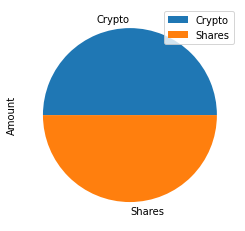

In [22]:
df_saving.plot(kind ="pie",subplots=True)

- Analyzing Savings

In [24]:
emergency_fund = monthly_income * 3
total_saving = total_crypto+total_share
if total_saving > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund")
elif total_saving == emergency_fund:
    print("Congratulations! on reaching your financial goal")
elif total_saving < emergency_fund:
    print((emergency_fund-total_saving), "dollars away from your goal")

Congratulations! You have enough money in your emergency fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

- Preparing Data

In [27]:
start_date = pd.Timestamp('2015-01-21', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-01-21', tz='America/New_York').isoformat()
portfolio_data = alpaca.get_barset(tickers,timeframe,start=start_date,end=end_date).df
historical_data = pd.DataFrame()
historical_data["AGG"]= portfolio_data["AGG"]["close"]
historical_data["SPY"]= portfolio_data["SPY"]["close"]
historical_data.index = historical_data.index.date
historical_data.head()

AGG     SPY
2015-01-21  111.5000  203.09
2015-01-22  111.4299  206.09
2015-01-23  111.7400  204.95
2015-01-26  111.6500  205.46
2015-01-27  111.6300  202.75

- Setting Simulation Instance

In [28]:
mc_fiveyear = MCSimulation(portfolio_data=portfolio_data,weights=[0.4,0.60],num_simulation=500,num_trading_days=7560)
mc_fiveyear.portfolio_data.head()

AGG                                       \
                             open    high       low     close   volume   
time                                                                     
2015-01-21 00:00:00-05:00  111.68  111.81  111.3901  111.5000  1916736   
2015-01-22 00:00:00-05:00  111.72  111.72  111.2900  111.4299  1868700   
2015-01-23 00:00:00-05:00  111.65  111.81  111.5400  111.7400  1449774   
2015-01-26 00:00:00-05:00  111.79  111.79  111.4500  111.6500  2477962   
2015-01-27 00:00:00-05:00  111.97  111.97  111.5450  111.6300  1538783   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2015-01-21 00:00:00-05:00          NaN  201.50  203.66  200.94  203.09   
2015-01-22 00:00:00-05:00    -0.000629  203.99  206.26  202.33  206.09   
2015-01-23 00:00:00-05:00     0.002783  205.79  206.10  204.81  204.95   
2015-01-26 00:00:00-05:00    -0.000805  204.71  205.56  203.85  205.46   
2015-01-27 00:00:00-05:00    -0.000179  202.97  204.12  201.74  202.75   

                                                   
                              volume daily_return  
time                                               
2015-01-21 00:00:00-05:00  106170094          NaN  
2015-01-22 00:00:00-05:00  124570218     0.014772  
2015-01-23 00:00:00-05:00   90576108    -0.005532  
2015-01-26 00:00:00-05:00   71274935     0.002488  
2015-01-27 00:00:00-05:00  109506387    -0.013190

- Running Simulation

In [29]:
mc_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1         2         3         4         5         6    \
0     1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.002651   0.999971  0.999226  1.001194  1.002751  1.000957  0.999336   
2     1.006892   1.004339  1.004026  0.991777  1.005162  1.000348  1.006071   
3     1.002125   1.005588  1.013729  0.999245  1.007031  1.001894  0.992664   
4     1.004688   1.010948  1.011948  0.995236  1.009160  1.007684  0.991656   
...        ...        ...       ...       ...       ...       ...       ...   
7556  7.418559  11.752105  6.290841  4.291647  5.853081  3.100268  5.755271   
7557  7.408352  11.786283  6.307754  4.275844  5.821141  3.106492  5.787873   
7558  7.385741  11.885504  6.313652  4.260976  5.828155  3.107016  5.801991   
7559  7.460555  11.860012  6.311994  4.263848  5.776743  3.112333  5.816586   
7560  7.422073  11.815060  6.399582  4.282536  5.789170  3.103318  5.862042   

           7          8         9    ...       490       491       492  \
0     1.000000   1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.992799   1.002662  1.006806  ...  1.007684  0.997199  1.000901   
2     0.997772   1.000252  1.011607  ...  1.007068  0.992569  1.004503   
3     1.000224   1.002818  1.008909  ...  1.005248  0.983301  1.004465   
4     1.009666   1.001161  1.007102  ...  0.997536  0.989042  0.998093   
...        ...        ...       ...  ...       ...       ...       ...   
7556  3.949272  11.824760  4.405770  ...  5.249553  7.402719  7.592062   
7557  3.923032  11.765497  4.413355  ...  5.244249  7.444708  7.541860   
7558  3.922754  11.823634  4.422064  ...  5.245254  7.397911  7.650701   
7559  3.969481  11.858775  4.430715  ...  5.232884  7.436138  7.693239   
7560  3.951757  11.838512  4.410340  ...  5.221167  7.423868  7.671287   

            493       494       495       496       497       498       499  
0      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1      1.008772  1.000370  0.993287  1.003120  1.000727  1.004612  0.989748  
2      1.012251  1.008841  1.002550  1.001028  1.007845  1.012897  0.982142  
3      1.014404  1.011478  0.997485  0.999594  1.008023  1.016619  0.981247  
4      1.014471  1.013414  0.992796  0.997132  0.996992  1.013003  0.980820  
...         ...       ...       ...       ...       ...       ...       ...  
7556  11.902620  6.244765  4.149217  8.005816  8.443989  5.392952  8.797962  
7557  11.800228  6.292859  4.126502  7.975437  8.404385  5.375155  8.692242  
7558  11.917651  6.301537  4.137200  7.928786  8.434043  5.421813  8.712148  
7559  11.919641  6.323591  4.091721  7.872142  8.411054  5.459841  8.649426  
7560  11.910675  6.312420  4.118003  7.843967  8.364926  5.452879  8.575948  

[7561 rows x 500 columns]

- Plotting Simulation

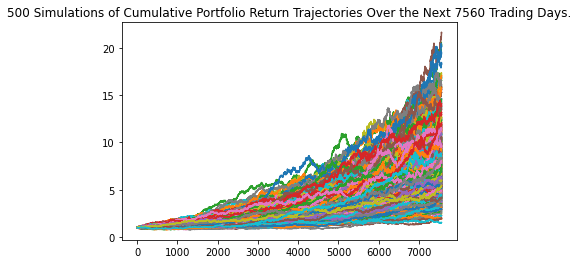

In [30]:
line_plot = mc_fiveyear.plot_simulation()

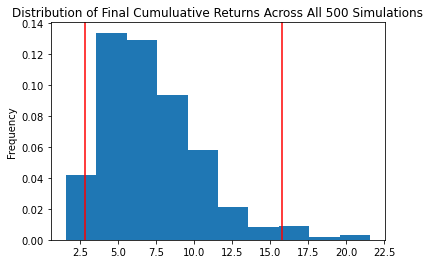

In [31]:
dist_plot = mc_fiveyear.plot_distribution()

### Retirement Analysis

- Summary Statistics

In [32]:
summary = mc_fiveyear.summarize_cumulative_return()
summary

count           500.000000
mean              7.228404
std               3.207443
min               1.539472
25%               4.886978
50%               6.623664
75%               8.994072
max              21.589846
95% CI Lower      2.826616
95% CI Upper     15.755638
Name: 7560, dtype: float64

- Calculating Returns Based On 20K Investment

In [33]:
initial_investment = 20000
ci_lower = round(summary[8]*initial_investment,2)
ci_upper = round(summary[9]*initial_investment,2)
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $56532.32 and $315112.76


- Calculating Returns Based On 30K Investment

In [34]:
initials_investment = 20000 * 1.5
ci_lowers = round(summary[8]*initials_investment,2)
ci_uppers = round(summary[9]*initials_investment,2)
print(f"There is a 95% chance that an initial investment of ${initials_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lowers} and ${ci_uppers}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $84798.49 and $472669.13
